# Data preprocessing of `.parquet` file

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load libraries

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow 
import seaborn as sns

from datetime import datetime

%matplotlib inline

pd.set_option('mode.chained_assignment',None)

### Load speakers from the `.parquet` file

In [3]:
PARQUET_PATH = "/content/drive/MyDrive/Project datasets/speaker_attributes.parquet"

In [4]:
speakers = pd.read_parquet(PARQUET_PATH)
print("The .parquet dataset contains ", speakers.shape[0], " rows.")
speakers.head()

The .parquet dataset contains  9055981  rows.


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


There is an enormous amount of speakers (>9M). We need to filter out all the speakers we don't need for our analysis.

### Extraction of speakers

#### 1. Extracting politicians affiliated with at least one political party

In [5]:
OCCUPATION_POLITICIAN_QID = 'Q82955'

speakers = speakers[speakers.occupation.notna() & speakers.party.notna()]
politicians = speakers[speakers.occupation.apply(lambda x: OCCUPATION_POLITICIAN_QID in x)]

print("There are ", politicians.shape[0], " politicians affiliated with at least one political party.")
politicians.head()

There are  305134  politicians affiliated with at least one political party.


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
5,"[Augusto Pinochet Ugarte, Augusto José Ramón P...",[+1915-11-25T00:00:00Z],[Q298],[Q6581097],1392242213,None,None,"[Q189290, Q82955]",[Q327591],None,Q368,Augusto Pinochet,None,item,[Q1841]
11,"[Gabriel González Videla, Gabriel Gonzales Vid...",[+1898-11-22T00:00:00Z],[Q298],[Q6581097],1329810558,None,None,"[Q40348, Q193391, Q82955]",[Q1759368],None,Q815,Gabriel Gonzáles Videla,[Q1069391],item,None
15,[Donald Franciszek Tusk],[+1957-04-22T00:00:00Z],[Q36],[Q6581097],1390487039,None,None,"[Q82955, Q201788]","[Q156868, Q208242]",None,Q946,Donald Tusk,[Q2586050],item,[Q9592]


At the moment, we have about 300K politicians. 
<br>However, we can easily notice that we have included people that are no longer alive (e.g. George Washington in first line).

#### 2. Extracting _alive_ politicians affiliated with at least one political party

Let us see how _old_ are our politicians in the dataset.

Text(0.5, 1.0, 'The age distribution of politicians')

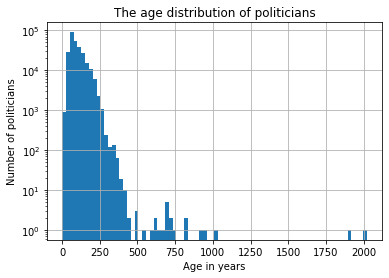

In [6]:
politicians = politicians[politicians.date_of_birth.notna()]
politicians.loc[:, 'age'] = politicians.date_of_birth.apply(lambda x: abs((datetime.strptime(x[-1][1:5],"%Y").year - datetime.now().year)))

politicians_age_hist = politicians.age.hist(log=True, bins=80)
politicians_age_hist.set_xlabel("Age in years")
politicians_age_hist.set_ylabel("Number of politicians")
plt.title("The age distribution of politicians")

On the above-painted plot we can notice that there is a huge amount of politicians that were born more than 100 years ago.
<br>We are assuming that the majority of politicians that were born before 1914, were already dead by the time of printing their quotes in 2015.
<br>In order to avoid the influence of these politicians, we will remove all the speakers that were born before 1914 (i.e. today's age of 107 years). 

In [7]:
politicians_alive = politicians[politicians.age < 107]
print(politicians_alive.shape)
politicians_alive.head()

(178695, 16)


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,age
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]",75
5,"[Augusto Pinochet Ugarte, Augusto José Ramón P...",[+1915-11-25T00:00:00Z],[Q298],[Q6581097],1392242213,None,None,"[Q189290, Q82955]",[Q327591],None,Q368,Augusto Pinochet,None,item,[Q1841],106
15,[Donald Franciszek Tusk],[+1957-04-22T00:00:00Z],[Q36],[Q6581097],1390487039,None,None,"[Q82955, Q201788]","[Q156868, Q208242]",None,Q946,Donald Tusk,[Q2586050],item,[Q9592],64
18,"[Namo, Modi, Narendra Bhai, Narendra Damodarda...",[+1950-09-17T00:00:00Z],[Q668],[Q6581097],1395415052,"[Q1282294, Q6889284]",None,"[Q82955, Q36180, Q7019111, Q10429346]",[Q10230],None,Q1058,Narendra Modi,"[Q63988227, Q63988919, Q16841231, Q16251961, Q...",item,[Q9089],71
19,"[Indira Nehru, Indira Priyadarshini Gandhi, In...",[+1917-11-19T00:00:00Z],"[Q668, Q129286, Q1775277]",[Q6581072],1390256502,[Q1996554],None,[Q82955],[Q10225],None,Q1149,Indira Gandhi,"[Q3532192, Q3531393]",item,[Q9089],104


#### 3. Extracting politicians affiliated with a US party

At the moment we have ~170K politicians, however, we are interested in only US politicians. Hence, we should extract those politicians that are affiliated with a US party.
<br>Firstly, let us find out if there are speakers that are associated with multiple parties.

In [20]:
politicians_alive.loc[:, ('party_count')] = politicians_alive.party.apply(lambda x: len(x))
max_num_parties = politicians_alive.party_count.max()
multiple_parties_count = politicians_alive[politicians_alive.party_count > 1].shape

print("The maximum number of parties for one speaker is ", max_num_parties, ".")
print("There are ", multiple_parties_count[0], " speakers that are associated with at least two political parties.")


The maximum number of parties for one speaker is  9 .
There are  16030  speakers that are associated with at least two political parties.


As can be seen, there is a lot of politicians affiliated with multiple parties. This, we should have in mind during further analysis.

Our next step is to extract US politicians. We are only interested in politicians affiliated with at least one US party (i.e. Republican or Democratic party).

In [21]:
REPUBLICAN_PARTY_QID = 'Q29468'
DEMOCRATIC_PARTY_QID = 'Q29552'

us_politicians = politicians_alive[politicians_alive.party.apply(lambda x: (REPUBLICAN_PARTY_QID in x)
                                                                 | (DEMOCRATIC_PARTY_QID in x))]
us_politicians.shape

(21705, 17)

There are about 21K politicians that were affiliated with a US party once in their lifetime.
<br> For our analysis, it is important that we know to which party the politician belonged when he was quoted. It is possible that a politician switched parties during his/hers lifetime - this should be taken into account as well.

If a politician belonged to multiple parties during the period 2015-2020 we will insert this politician multiple times in the dataset, each time with different party-start and end dates.

In [23]:
us_politicians.loc[:, "party_start_date"] = None
us_politicians.loc[:, "party_end_date"] = None

##### a) Extracting politicians affiliated with only one US party

In [24]:
us_politicians_unique_party = us_politicians[us_politicians.party.apply(lambda x: len(x) == 1)]
print(us_politicians_unique_party.shape)

(20351, 19)


There are ~20K US politicians that are affilated with a single US party.

##### b) Handling politicians affiliated with multiple parties (but at least one US party)

In [25]:
us_politicians_multiple_party = us_politicians[us_politicians.party.apply(lambda x: len(x) > 1)]
print(us_politicians_multiple_party.shape)
us_politicians_multiple_party.head()

(1354, 19)


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,age,party_count,party_start_date,party_end_date
10098,None,[+1928-11-11T00:00:00Z],[Q30],[Q6581097],1392741346,None,Z000013,[Q82955],"[Q29468, Q29552]",None,Q265668,Edward Zorinsky,None,item,[Q9268],93,2,None,None
11762,"[Henry Ross Perot, H. Ross Perot, Henry Ray Pe...",[+1930-06-27T00:00:00Z],[Q30],[Q6581097],1393140990,None,None,"[Q10669499, Q82955, Q131524]","[Q29468, Q1893430]",None,Q313697,Ross Perot,[Q659166],item,None,91,2,None,None
18541,None,[+1938-04-15T00:00:00Z],[Q30],[Q6581097],1392460323,None,None,"[Q47064, Q82955]","[Q29552, Q29468]",None,Q489037,Jay Garner,None,item,None,83,2,None,None
20263,[Albio B. Sires],[+1951-01-26T00:00:00Z],"[Q30, Q241]",[Q6581097],1393425845,None,S001165,"[Q82955, Q37226, Q43845]","[Q29552, Q29468]",None,Q527509,Albio Sires,None,item,None,70,2,None,None
23224,None,[+1940-10-07T00:00:00Z],[Q30],[Q6581097],1393283295,None,V000087,"[Q82955, Q37226]","[Q1937395, Q29552]",None,Q609379,Bruce Vento,None,item,[Q9592],81,2,None,None


~1300 politicians are affiliated with multiple parties. In order to extract at which time they belonged to which party we need to perform additional analysis (e.g. querying wikidata).

When sending a SPARQL query we will use the ID's of the ~1300 politicians. However, this is too much and should be split into smaller chunks (e.g. chunk size ~350).
<br>At the same time, the query will:
- check if politician is alive or died after 2015
- extract parties between 2015-2020 for each politician

In [27]:
qids_multiple_party = us_politicians_multiple_party.id.apply(lambda x: "wd:"+x)
qids_multiple_party = qids_multiple_party.tolist()

CHUNK_SIZE = 350
qids_multiple_party_chunks = [qids_multiple_party[x:x+CHUNK_SIZE] for x in range(0, len(qids_multiple_party), CHUNK_SIZE)]

In [28]:
import requests

us_politicians_party = us_politicians_unique_party 

url = 'https://query.wikidata.org/sparql'
query_start = '''
    SELECT ?item ?party ?startDate ?endDate WHERE{ 
      ?item
      p:P102 ?statement.
      ?statement ps:P102 ?party.

      OPTIONAL {
        ?statement pq:P580 ?startDate.
      }

      OPTIONAL {
        ?statement pq:P582 ?endDate.
      }

      OPTIONAL {
        ?item wdt:P570 ?dday.  
      }

      FILTER (?item in (
      ''' 
query_end = '''
        ))
      
      FILTER ((bound(?endDate) && year(?endDate) > 2015) || (bound(?startDate) && !bound(?endDate)))
  
      FILTER (!bound(?dday) || year(?dday) > 2015) 
  
      SERVICE wikibase:label {
        bd:serviceParam wikibase:language "en" .
      }
    }
    ORDER BY ?item ?startDate
'''

for chunk in qids_multiple_party_chunks:
    
    chunk_string = ",".join(chunk)
    query = query_start + chunk_string + query_end
    
    r = requests.get(url, params = {'format': 'json', 'query': query})
    data = r.json()

    for result in data["results"]["bindings"]:
        
        qid = result["item"]["value"].split('/')[-1]
        party = result["party"]["value"].split('/')[-1]
        party_start_date = result.get("startDate", {}).get("value", {})
        party_end_date = result.get("endDate", {}).get("value", {})
        
        politician = us_politicians_multiple_party.loc[us_politicians_multiple_party['id'] == qid]
        politician.loc[:, ('party')] = party
        politician.loc[:, ('party_start_date')] = party_start_date if bool(party_start_date) else None
        politician.loc[:, ('party_end_date')] = party_end_date if bool(party_end_date) else None
        
        us_politicians_party = us_politicians_party.append(politician, ignore_index=True)
    
print(us_politicians_party.shape)
us_politicians_party.tail()

(20459, 19)


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,age,party_count,party_start_date,party_end_date
20454,"[William F. Weld, William Floyd Weld, William ...",[+1945-07-31T00:00:00Z],[Q30],[Q6581097],1393565868,None,None,"[Q40348, Q6625963, Q82955]",Q558334,None,Q720242,Bill Weld,[Q38051523],item,[Q682443],76,3,2016-05-01T00:00:00Z,2019-01-01T00:00:00Z
20455,"[William F. Weld, William Floyd Weld, William ...",[+1945-07-31T00:00:00Z],[Q30],[Q6581097],1393565868,None,None,"[Q40348, Q6625963, Q82955]",Q29468,None,Q720242,Bill Weld,[Q38051523],item,[Q682443],76,3,2019-01-17T00:00:00Z,None
20456,None,[+1940-10-31T00:00:00Z],[Q30],[Q6581097],1392111332,None,None,[Q82955],Q29552,None,Q7287985,Ralph R. Caputo,None,item,None,81,2,1982-01-01T00:00:00Z,None
20457,"[Wilbur L. Ross, Jr., Wilbur Louis Ross Jr.]",[+1937-11-28T00:00:00Z],[Q30],[Q6581097],1393402827,None,None,"[Q1979607, Q557880, Q82955, Q806798, Q10732476]",Q29552,None,Q8000233,Wilbur Ross,None,item,[Q1841],84,2,None,2016-01-01T00:00:00Z
20458,"[Wilbur L. Ross, Jr., Wilbur Louis Ross Jr.]",[+1937-11-28T00:00:00Z],[Q30],[Q6581097],1393402827,None,None,"[Q1979607, Q557880, Q82955, Q806798, Q10732476]",Q29468,None,Q8000233,Wilbur Ross,None,item,[Q1841],84,2,2016-01-01T00:00:00Z,None


### Removing unnecessary columns

At the moment our dataset has 19 columns. However, some of them (e.g. lastrevid, type, etc.) are not important for our analysis and should be removed before exporting the dataset in order to reduce memory consumption.

In [33]:
unnecessary_columns = ['lastrevid', 'aliases', 'type', 'party_count']
us_politicians_party = us_politicians_party.drop(columns=unnecessary_columns)

us_politicians_party.head()

,date_of_birth,nationality,gender,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,religion,age,party_start_date,party_end_date
0,[+1946-07-06T00:00:00Z],[Q30],[Q6581097],None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]","[Q329646, Q682443, Q33203]",75,None,None
1,[+1947-03-12T00:00:00Z],[Q30],[Q6581097],None,R000615,"[Q82955, Q15978655, Q43845, Q15980158, Q219477]",[Q29468],"[Q1765120, Q191701, Q1540185]",Q4496,Mitt Romney,"[Q937607, Q4226, Q4791860, Q17100322]",[Q42504],74,None,None
2,[+1938-08-15T00:00:00Z],[Q30],[Q6581097],None,None,"[Q185351, Q16533, Q40348, Q1622272, Q82955]",[Q29552],None,Q11124,Stephen Breyer,None,[Q9268],83,None,None
3,[+1954-05-20T00:00:00Z],[Q30],[Q6581097],[Q49085],None,[Q82955],[Q29552],None,Q11674,David Paterson,None,None,67,None,None
4,[+1951-09-02T00:00:00Z],[Q30],[Q6581097],None,D000595,"[Q82955, Q2961975]",[Q29468],None,Q22201,Jim DeMint,None,[Q178169],70,None,None


### Exporting the dataset of US politicians

In [34]:
us_politicians_party.to_json('./us_politicians.json.bz2', compression='bz2', lines=True, orient='records')

##### check if reading works (should be deleted)

In [35]:
data = pd.read_json('./us_politicians.json.bz2', compression='bz2', lines=True, orient='records')
data.shape

(20459, 15)